<font size="6"><center>**Model Building: Basics**</font>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%run ../nb_config.py

running notebook configuration


In [ ]:
import numpy as np
import pandas as pd


In [ ]:
from src.data_api import sources, sinks
from src import utils, tags

from src import mle 

In [ ]:
conf = utils.get_conf()

In [ ]:
fparams = conf['func_params']

start_dt = fparams['start_dt']
end_dt = fparams['end_dt']
avol_top = float(fparams['avol_top'])
avol_window = int(fparams['avol_window'])
tau = int(fparams['target']['tau'])

val_dt = fparams['split_dt']['valid']
test_dt = fparams['split_dt']['test']

In [ ]:
start_dt, val_dt, test_dt, end_dt

('2015-01-01', '2016-12-31', '2017-06-30', '2017-12-31')

In [ ]:
RND_SEED = 123

# Load Data

In [ ]:
feats_and_targets = sources.read_data(
    'feats_and_targets.csv', layer='interim',
    parse_dates=['date'], index_col=['date', 'ticker'])
feats_and_targets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 374331 entries, (Timestamp('2015-01-02 00:00:00'), 'A') to (Timestamp('2017-12-29 00:00:00'), 'ZTS')
Columns: 28 entries, sector to split_3f
dtypes: bool(1), float64(24), object(3)
memory usage: 79.0+ MB


In [ ]:
pd.concat([feats_and_targets.head(2), feats_and_targets.tail(2)], axis=0)

,,sector,SP500,y_fwd_logrets_5d,x_intrad_upshadow,x_intrad_loshadow,x_returns_1d,x_returns_5d,x_zscore_5d,x_zscore_vol_5d,x_macd_5d_vs_20d,x_rsi,x_zscore_20d,x_zscore_vol_20d,x_zscore_60d,x_zscore_vol_60d,x_bb_60d,x_macd_50d_vs_252d,x_returns_1y,x_rets5d_vol_60d,x_rets5d_vol_120d,x_mkt_dispersion,x_wday_cos,x_wday_sin,x_is_eoq,x_mkt_volat_60d,x_mkt_volat_120d,split,split_3f
date,ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,A,Capital Goods,-0.0147,0.0007,0.1264,0.1847,-0.0069,-0.0115,-1.4744,0.9398,0.2672,55.3864,-0.1928,-0.5010,0.1058,-0.8054,0.0000,0.4378,0.1129,0.0405,0.0336,0.0543,0.3090,-0.9511,False,0.0236,0.0192,1.dev,1.train
2015-01-05,A,Capital Goods,-0.0341,0.0078,0.1361,0.0972,-0.0189,-0.0365,-1.5635,1.5077,0.0948,55.6667,-0.8393,-0.0693,-0.3988,-0.4243,0.0000,0.4540,0.1001,0.0406,0.0338,0.0628,1.0000,0.0000,False,0.0241,0.0194,1.dev,1.train
2017-12-28,ZTS,Health Care,0.0011,0.0133,0.1100,0.2500,-0.0008,-0.0044,0.5586,-1.2001,0.2580,59.9842,0.6349,-1.4923,1.0820,-1.6623,0.0000,8.6920,0.3552,0.0237,0.0218,0.0547,-0.8090,-0.5878,False,0.0057,0.0068,2.test,3.test
2017-12-29,ZTS,Health Care,-0.0036,0.0301,0.2100,0.0000,-0.0048,-0.0033,-0.9547,1.3702,0.2225,65.2919,0.0366,-0.0578,0.9494,-0.5330,0.0000,8.7416,0.3557,0.0238,0.0218,0.0637,0.3090,-0.9511,False,0.0056,0.0068,2.test,3.test


In [ ]:
feats_and_targets.columns

Index(['sector', 'SP500', 'y_fwd_logrets_5d', 'x_intrad_upshadow',
       'x_intrad_loshadow', 'x_returns_1d', 'x_returns_5d', 'x_zscore_5d',
       'x_zscore_vol_5d', 'x_macd_5d_vs_20d', 'x_rsi', 'x_zscore_20d',
       'x_zscore_vol_20d', 'x_zscore_60d', 'x_zscore_vol_60d', 'x_bb_60d',
       'x_macd_50d_vs_252d', 'x_returns_1y', 'x_rets5d_vol_60d',
       'x_rets5d_vol_120d', 'x_mkt_dispersion', 'x_wday_cos', 'x_wday_sin',
       'x_is_eoq', 'x_mkt_volat_60d', 'x_mkt_volat_120d', 'split', 'split_3f'],
      dtype='object')

# Data Preparation

In [ ]:
features = feats_and_targets.filter(regex='x_').columns
label = 'y_fwd_logrets_5d'

In [ ]:
features

Index(['x_intrad_upshadow', 'x_intrad_loshadow', 'x_returns_1d',
       'x_returns_5d', 'x_zscore_5d', 'x_zscore_vol_5d', 'x_macd_5d_vs_20d',
       'x_rsi', 'x_zscore_20d', 'x_zscore_vol_20d', 'x_zscore_60d',
       'x_zscore_vol_60d', 'x_bb_60d', 'x_macd_50d_vs_252d', 'x_returns_1y',
       'x_rets5d_vol_60d', 'x_rets5d_vol_120d', 'x_mkt_dispersion',
       'x_wday_cos', 'x_wday_sin', 'x_is_eoq', 'x_mkt_volat_60d',
       'x_mkt_volat_120d'],
      dtype='object')

In [ ]:
feats_and_targets = feats_and_targets.replace({np.inf: np.nan, -np.inf: np.nan}).fillna(0.)

# Splitting

Define a column to split data into 2 or 3 folds (depending on your model building strategy). In general:


Train/Val/Test:
* Use train to fit model, Val to assess performance and probing different hyperparameters and test to yield a honest (final) performance metric

Cross-Validation:
* Use dev/test folds, in dev fold apply a Cross-validation algorithm that will sucesivelly split in train/valid
* Once again, use test to yield a honest (final) performance metri

In [19]:
feats_and_targets['split_3f'].value_counts(normalize=True)

1.train   0.6695
2.valid   0.1657
3.test    0.1647
Name: split_3f, dtype: float64

In [20]:
start_dt, val_dt, test_dt, end_dt

('2015-01-01', '2016-12-31', '2017-06-30', '2017-12-31')

In [18]:
df_train = feats_and_targets.query('split_3f == "1.train"')
X_train = df_train[features]
y_train = df_train[label]

df_valid = feats_and_targets.query('split_3f == "2.valid"')
X_valid =  df_valid[features]
y_valid =  df_valid[label]

df_test = feats_and_targets.query('split_3f == "3.test"')
X_test =  df_test[features]
y_test =  df_test[label]

# Model Building

`ParameterGrid`  allows to itererate over a grid of hyper-params

In [21]:
from sklearn.model_selection import ParameterGrid

grid_hparams = {
    'fit_intercept': [False, True],
    'alpha': [0.001, 0.0001], 
               }
grid_hparams = ParameterGrid(grid_hparams)

for hparams in grid_hparams:
    print(hparams)


{'alpha': 0.001, 'fit_intercept': False}
{'alpha': 0.001, 'fit_intercept': True}
{'alpha': 0.0001, 'fit_intercept': False}
{'alpha': 0.0001, 'fit_intercept': True}


In [22]:
len(grid_hparams)

4

In [25]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as skl_mse
model = Lasso(random_state=RND_SEED)

res = {'idx': [], 'model': [], 'hparams': [], 'train_rmse': [], 'val_rmse': []}

for i, hparams in enumerate(grid_hparams):
    # instanciate model
    model = Lasso(random_state=RND_SEED, **hparams)
    # fit model on train
    model.fit(X_train, y_train)
    # predict and assess on train and valid
    p_train = model.predict(X_train)
    train_rmse =  np.sqrt(skl_mse(y_train, p_train))
    p_valid = model.predict(X_valid)
    val_rmse =  np.sqrt(skl_mse(y_valid, p_valid))
    # store results
    res['idx'].append(i)
    res['model'].append(model)
    res['hparams'].append(hparams)
    res['train_rmse'].append(train_rmse)
    res['val_rmse'].append(val_rmse)


In [26]:
hparams

{'alpha': 0.0001, 'fit_intercept': True}

In [28]:
res['train_rmse']

[0.08532724214261692,
 0.08532601541113491,
 0.08527250221718813,
 0.08521569608677378]

In [29]:
res['val_rmse']

[0.0720259437778695,
 0.07203199982892511,
 0.07207907724733775,
 0.07214050962309944]

In [30]:
best_model = res['model'][0]

It can be seen that hparams configuration `idx=0` yields the lowest rmse

# Predictions

In [33]:
p_valid = pd.Series(index=X_valid.index, data=best_model.predict(X_valid), name='preds')

In [34]:
p_valid.head(2)  

date        ticker
2017-01-12  A        -0.0007
2017-01-13  A        -0.0019
Name: preds, dtype: float64

Use predictions to build a strategy, this set of values is can be seen as a ml-alpha factor that combines all our features into a single signal

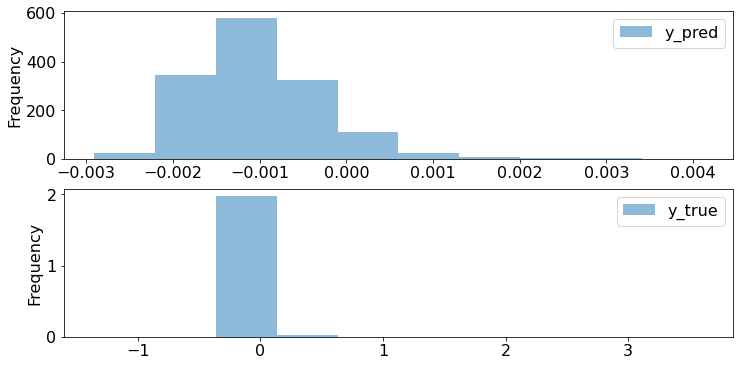

In [49]:
fig, axs = plt.subplots(2,1)

ax = axs[0]
p_valid.plot.hist(label='y_pred', alpha=0.5, density=True, ax=ax)
ax.legend()

ax = axs[1]
y_valid.plot.hist(label='y_true', alpha=0.5,  density=True, ax=ax)
ax.legend()
plt.show()

In [51]:
p_valid.describe()

count   62,045.0000
mean        -0.0010
std          0.0008
min         -0.0029
25%         -0.0015
50%         -0.0011
75%         -0.0006
max          0.0041
Name: preds, dtype: float64

In [50]:
y_valid.describe()

count   62,045.0000
mean        -0.0002
std          0.0720
min         -1.3549
25%         -0.0191
50%          0.0014
75%          0.0207
max          3.6065
Name: y_fwd_logrets_5d, dtype: float64

# Evaluation

(In ML terms, an evaluation in money terms needs a strategy on top of predictions and a proper backtesting on unseen data)

Tails in target distribution is a caveat to modelling, spececially with linear models

In [65]:
cm_train = pd.crosstab(
    index=y_train>0,
    columns= p_train>0,
    normalize=True  # also check 'index'
)
cm_train

col_0,False,True
y_fwd_logrets_5d,,
False,0.3629,0.1190
True,0.3623,0.1558


In [68]:
np.diag(cm_train).sum()

0.518709600191525

This model does not provide a good estimation on long positions, as it is skewed to the negative side

In [69]:
cm_valid = pd.crosstab(
    index=y_valid>0,
    columns= p_valid>0,
    normalize=True
)
cm_valid

preds,False,True
y_fwd_logrets_5d,,
False,0.4405,0.0405
True,0.4778,0.0412


In addition, this skew is more accute in valid data

In [70]:
np.diag(cm_valid).sum()

0.4816665323555484